# FDS final project 2022/2023

Group members:
- Federico Barreca 1736423 barreca.1736423@studenti.uniroma1.it
- Maria Vittoria Vestini 1795724 vestini.1795724@studenti.uniroma1.it
- Laura Mignella 1920520 mignella.1920520@studenti.uniroma1.it
- Cosmin Zaharia 1805207 zaharia.1805207@studenti.uniroma1.it
- Antonio Ratti 1700089 ratti.1700089@studenti.uniroma1.it

# Import libraries

In [ ]:
from nltk.corpus import stopwords
from tqdm import tqdm
from emoji import demojize
import neattext.functions as nfx
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import sparse
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import string
import re

# Load Dataset

In [ ]:
first_data = pd.read_csv('go_emotions_dataset.csv') #import dataset

Let's take a look inside the dataset

In [ ]:
first_data.head()

,id,text,example_very_unclear,admiration,amusement,anger,annoyance,approval,caring,confusion,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,eew5j0j,That game hurt.,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,eemcysk,>sexuality shouldn’t be a grouping category I...,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ed2mah1,"You do right, if you don't care then fuck 'em!",False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,eeibobj,Man I love reddit.,False,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,eda6yn6,"[NAME] was nowhere near them, he was by the Fa...",False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


# Analyze the data

Horizontal bar plot that shows the frequency of each emotion

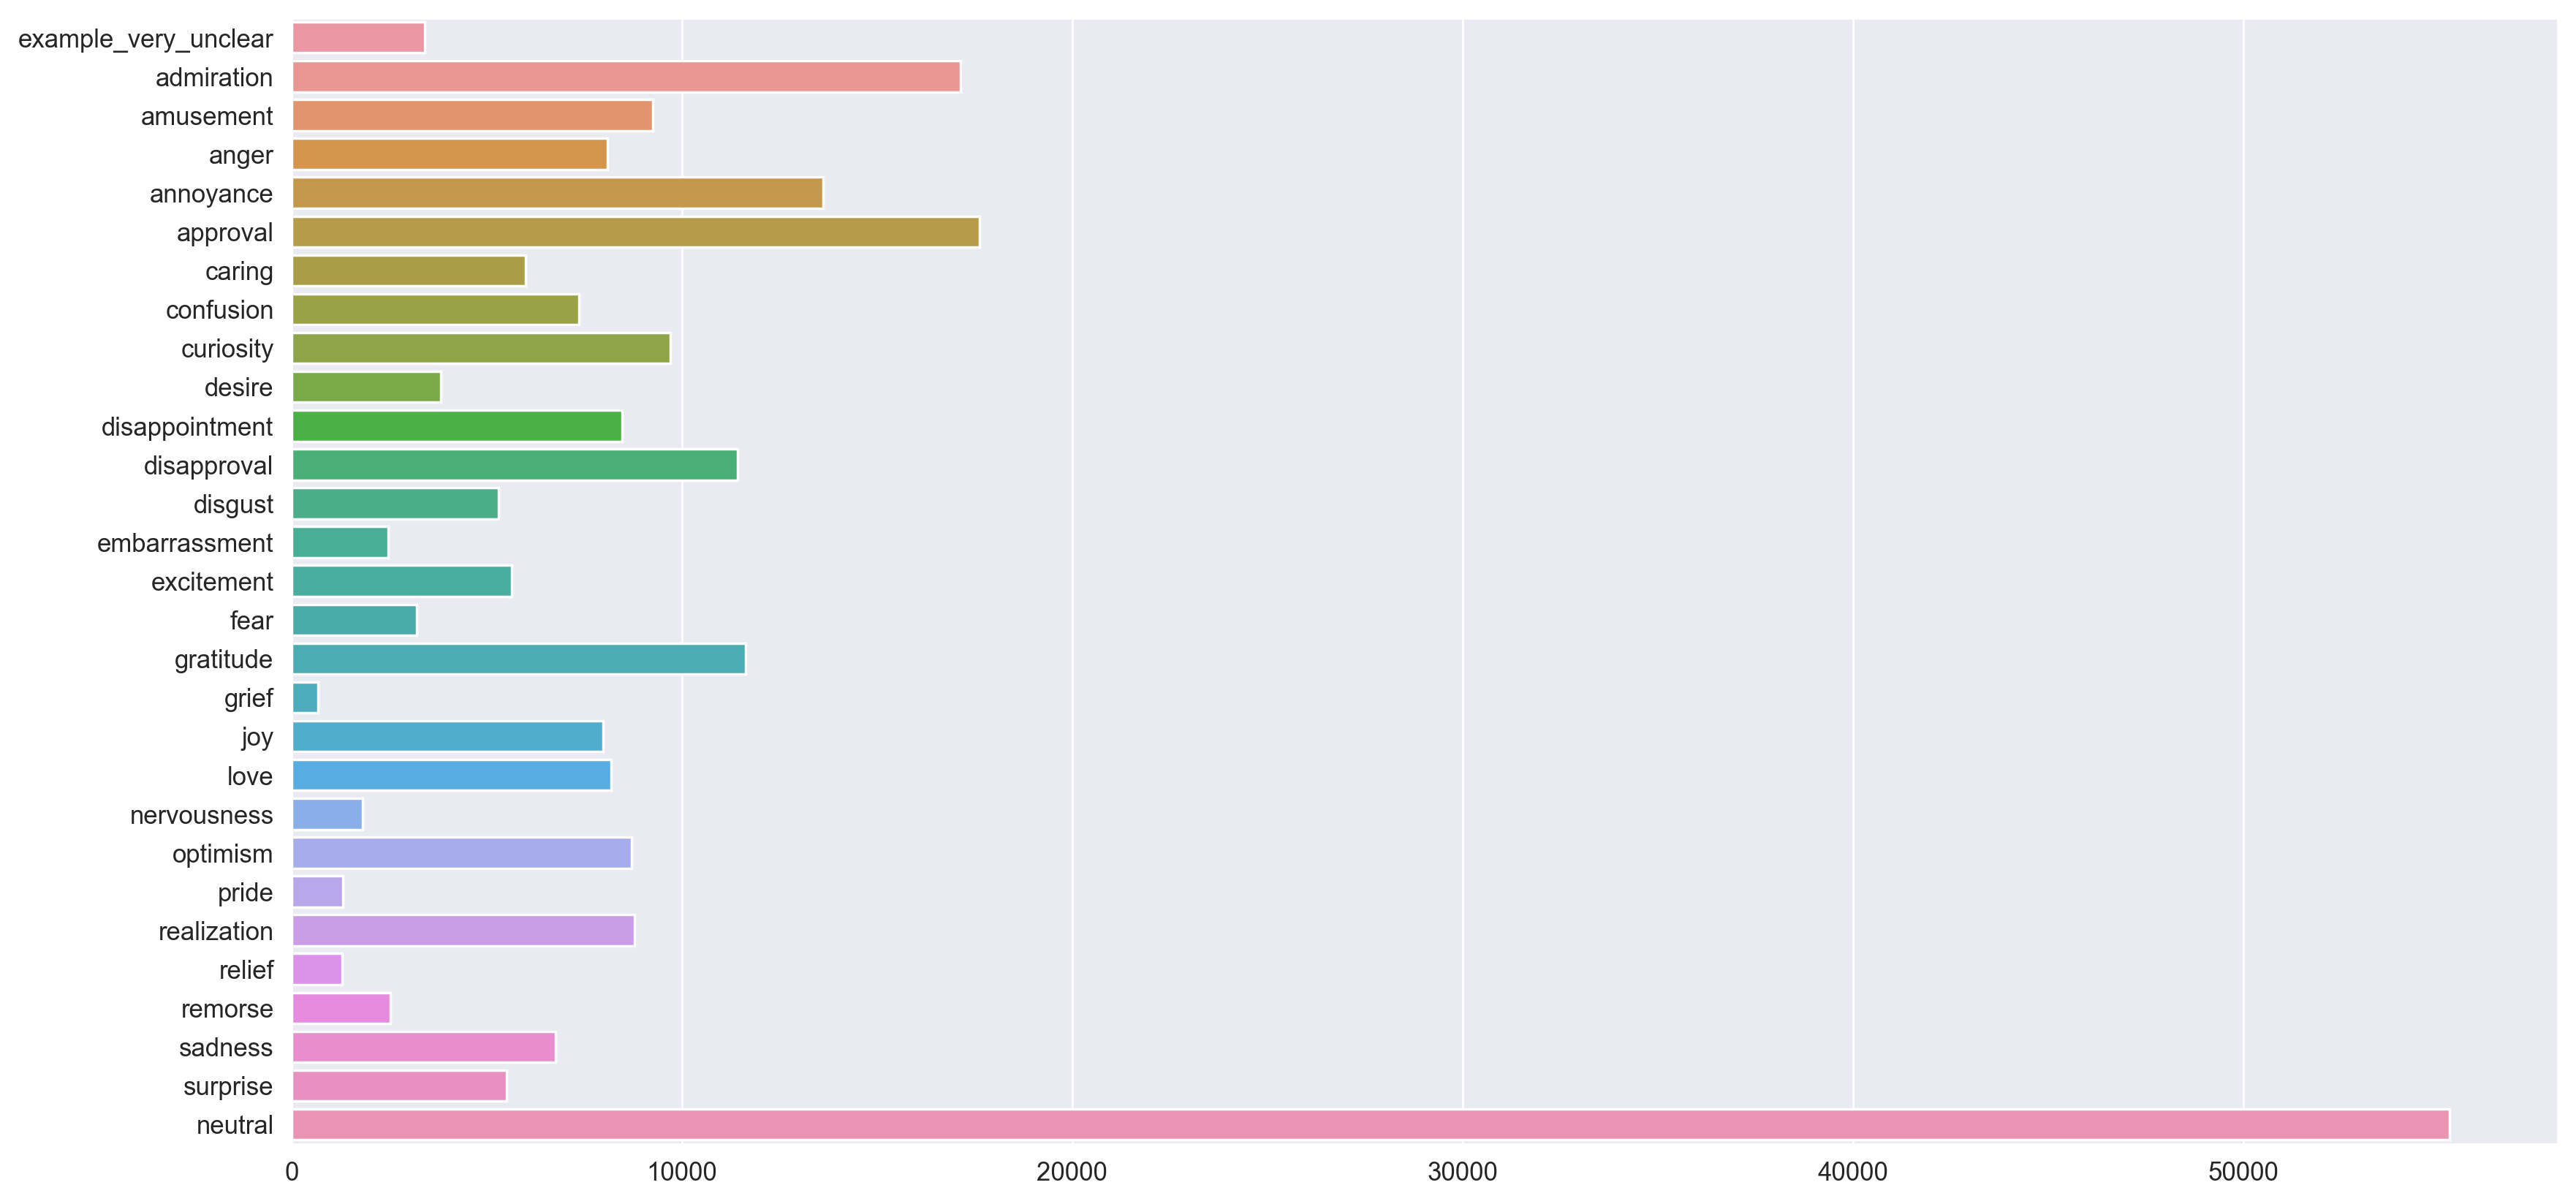

In [ ]:
values = first_data[first_data.columns[2:]].sum(axis=0)
emotions = first_data.columns[2:]

sns.set_style("darkgrid")
sns.set_palette('Set2')


fig, ax = plt.subplots(figsize=(16, 8), dpi=250)

sns.barplot(y = emotions, x = values, ax = ax)
plt.show()

The first thing that stands out is the *neutral's* frequency which obviously will bias our analysis for this reason we choose to drop this column. 

In addition, the column _"example_very_unclear"_ is a boolean value (True/False). The value is True if there isn't any emotion linked to the text, so we also get rid of this entries. 

In [ ]:
# Removing the rows that could create problems
first_data = first_data.drop(list(first_data[first_data["example_very_unclear"] == True].index))
first_data = first_data.drop(list(first_data[first_data["neutral"] == 1].index))

# Removing the columns that we don't need
del first_data['neutral']
del first_data["example_very_unclear"] 
del first_data['id']

# Data Cleaning (NLP)

Since we are going to train a text coming from Reddit, it would be full of emoji, abbrevetions, laughs, acronym and so on. For this reason, we apply NLP (Natural language processing) with the intention of reducing mistakes and improving data quality. The cleaning process includes the following action:

<lu>
    <li>User handles - removing user handles to reduce less useful data.</li>
    <li>Lower case - lowering case to maintain a consistent flow during text mining.</li>
    <li>Emojis - converting emojis to text so machines can understand what they mean.</li>
    <li>Punctuations - removing punctuations to minimize ambiguity.</li>
    <li>Stop words - removing stop words to minimize noise.</li>
    <li>Number - removing numbers to reduce less useful data.</li>
    <li>Single letter - removing single letters to reduce less meaningful words.</li>
    <li>Lemmatization - lemmatizing words to return words into their root form.</li>
</lu>

The following code contains all the text cleaning methods which have been discussed above.

In [ ]:
def NLP(dataset):
    # remove userhandles
    dataset['text'] = dataset['text'].apply(nfx.remove_userhandles)
    # lower casing
    dataset["text"] = dataset["text"].str.lower()
    # handle emojis
    dataset["text"] = dataset["text"].apply(lambda text: demojize(text))
    # remove puntuation
    punc_to_remove = string.punctuation

    def remove_punctuation(text):
        return text.translate(str.maketrans('','', punc_to_remove))

    dataset["text"] = dataset["text"].apply(lambda text: remove_punctuation(text))

    # remove the numbers and single letters
    def remove_numbers(string):
        pattern = "[0-9]+" 
        newS = re.sub(pattern, "", string)
        newS = re.sub(r"\b\d+\b *|\b[a-z]\b *","", newS)
        return(newS)

    dataset["text"] = dataset["text"].apply(lambda text: remove_numbers(text))

    # remove stopwords
    STOPWORDS = set(stopwords.words("english"))

    def remove_stopword(text):
        return " ".join([word for word in str(text).split() if word not in STOPWORDS])

    dataset["text"] = dataset["text"].apply(lambda text: remove_stopword(text))
    
    return dataset

In [ ]:
clean_dataset = NLP(first_data)

<hr>

# Choosing the data

### !! Disclaimer !!

There are two different ways (one for the emotion recognition classifier and the other for the sentiment analysis) to process the data, run only one of them.

## Six emotions, Emotion Recognition

According to the _Visual guide to human emotion_ (link: https://www.visualcapitalist.com/a-visual-guide-to-human-emotion/)

We have decided to group the emotions into six groups: joy, love, anger, fear, surprise, and sadness.

In [ ]:
# Grouping emotions to the 6 classes
joy = ['amusement', 'excitement', 'joy', 'optimism', 'pride', 'relief']
love = ['admiration', 'caring', 'desire', 'gratitude', 'love']
anger = ['anger', 'annoyance', 'disapproval']
fear = ['approval', 'embarrassment', 'fear', 'nervousness']
surprise = ['confusion', 'curiosity', 'realization', 'surprise']
sadness = ['disappointment', 'disgust', 'grief', 'remorse', 'sadness']

In [ ]:
first_data["joy"] = first_data[joy].max(axis=1)
first_data["love"] = first_data[love].max(axis=1)
first_data["anger"] = first_data[anger].max(axis=1)
first_data["fear"] = first_data[fear].max(axis=1)
first_data["surprise"] = first_data[surprise].max(axis=1)
first_data["sadness"] = first_data[sadness].max(axis=1)

### Create new dataset

We can notice that some texts have more that one emotion linked to them, so to avoid problems we select only the indexes that have one and only one of the 6 emotions.

In [ ]:
test_data = first_data[["text", "joy", "love", "anger", "fear", "surprise", "sadness"]] 

In [ ]:
test_data['sums'] = test_data[test_data.columns[1:]].sum(axis=1)
test_data = test_data.drop(list(test_data[test_data.sums>1].index))

del test_data['sums'] 

Now let's visualize the data

In [ ]:
test_data.head()

,text,joy,love,anger,fear,surprise,sadness
0,game hurt,0,0,0,0,0,1
3,man love reddit,0,1,0,0,0,0
5,right considering it’such important document k...,0,1,0,0,0,0
6,isnt big hes still quite popular ive heard thi...,0,0,1,0,0,0
7,thats crazy went super religion high school th...,1,0,0,0,0,0


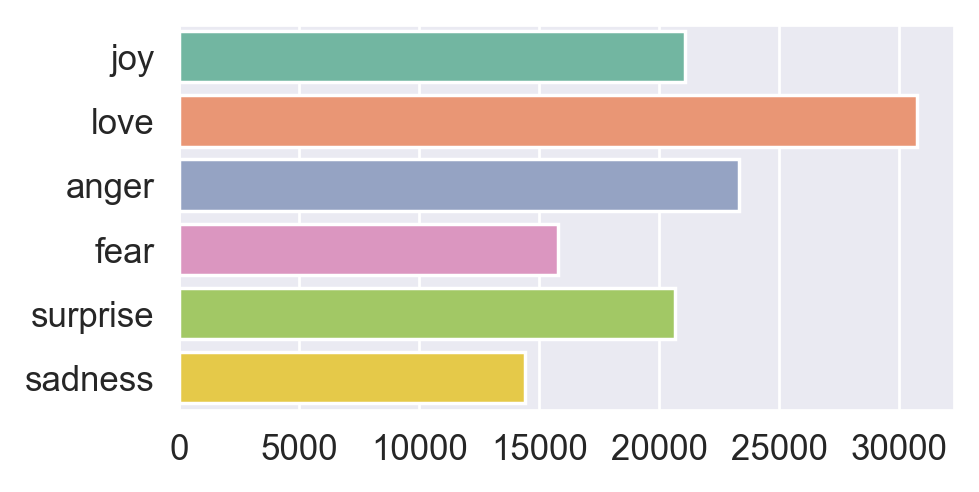

In [ ]:
values = test_data[test_data.columns[1:]].sum(axis=0)
emotions = test_data.columns[1:]

sns.set_style("darkgrid")
sns.set_palette('Set2')


fig, ax = plt.subplots(figsize=(4, 2), dpi=250)

sns.barplot(y = emotions, x = values, ax = ax)
plt.show()

## Binary model: Sentiment Analisys

Looking at the previous classificarion we noticed that the texts linked to the $\textit{surprise}$ emotions are ambiguous, so we decided to drop them in order to obtain a better result.

In [ ]:
# First we delate the entries of the dataset
clean_dataset = clean_dataset.drop(clean_dataset[clean_dataset['realization'] == 1].index)
clean_dataset = clean_dataset.drop(clean_dataset[clean_dataset['surprise'] == 1].index)
clean_dataset = clean_dataset.drop(clean_dataset[clean_dataset['confusion'] == 1].index)
clean_dataset = clean_dataset.drop(clean_dataset[clean_dataset['curiosity'] == 1].index)

# Then the columns
del clean_dataset['realization'] 
del clean_dataset['surprise'] 
del clean_dataset['confusion']
del clean_dataset['curiosity']

In [ ]:
positive=['admiration', 'amusement', 'approval', 'caring', 'desire', 'excitement', 'gratitude', 'joy', 'love',
          'optimism', 'pride', 'relief']
negative=['anger', 'annoyance', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'fear',
          'nervousness', 'remorse', 'grief', 'sadness']

In [ ]:
clean_dataset["positive"] = clean_dataset[positive].sum(axis=1)
clean_dataset["negative"] = clean_dataset[negative].sum(axis=1)

In [ ]:
test_data = clean_dataset[["text","positive","negative"]]

In [ ]:
test_data['sums'] = test_data[test_data.columns[1:]].sum(axis=1)
test_data = test_data.drop(list(test_data[test_data.sums>1].index))

del test_data['sums'] 

In [ ]:
test_data.head()

,text,positive,negative
0,game hurt,0,1
3,man love reddit,1,0
5,right considering it’such important document k...,1,0
6,isnt big hes still quite popular ive heard thi...,0,1
7,thats crazy went super religion high school th...,1,0


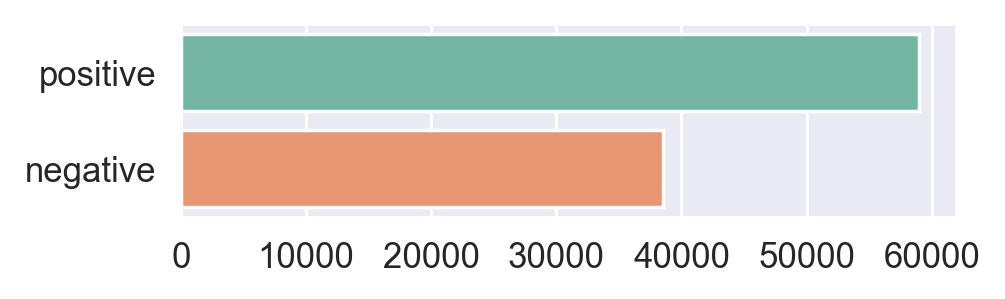

In [ ]:
values = test_data[test_data.columns[1:]].sum(axis=0)
emotions = test_data.columns[1:]

sns.set_style("darkgrid")
sns.set_palette('Set2')


fig, ax = plt.subplots(figsize=(4, 1), dpi=250)

sns.barplot(y = emotions, x = values, ax = ax)
plt.show()

## Final dataset

Now we have to create the final dataset. To do so we just need the text and the associated label.

With the function below we create the labels by multipling the columns names and the vector of each text (that has 1 only in the right emotion). 

In [ ]:
def define_label(x, columns):
    y = [0 if i!=np.argmax(x) else 1 for i,el in enumerate(x)]
    return ''.join([z*k for z,k in zip(y,columns)])

Define a new column using the function above: _label_

In [ ]:
test_data["label"] = test_data.apply(lambda x: define_label(np.array(x)[1:], test_data.columns[1:]) , axis = 1)

Final dataset

In [ ]:
clean_data = test_data[["text", "label"]]

In [ ]:
clean_data.head()

,text,label
0,game hurt,negative
3,man love reddit,positive
5,right considering it’such important document k...,positive
6,isnt big hes still quite popular ive heard thi...,negative
7,thats crazy went super religion high school th...,positive


<hr>

# Model and Train using a library

In this and the following section you will be able to see the results for the Binary Classifier. 

For the 6 emotion classifier results you can consult the report.

In [ ]:
Xfeature = clean_data['text']
Ylabel = clean_data['label']

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cv = CountVectorizer()
X = cv.fit_transform(Xfeature)

Splitting the dataset for a 80% training, 20% testing.

In [ ]:
# split dataset into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Ylabel, test_size=0.2, random_state=42)
print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)

Train: (78010, 28004) (78010,)
Test : (19503, 28004) (19503,)


## Logistic Regression

Let's apply the pre-implemented logistic regression classifier from $\textit{sklearn}$ to our dataset.

In [ ]:
from sklearn.linear_model import LogisticRegression

lrModel = LogisticRegression(max_iter = 10000)
lrModel.fit(X_train, y_train)

In [ ]:
print("Length of the model classes: ", len(lrModel.classes_))
print("Type of the model classes  : ", lrModel.classes_)
print("Model accuracy             : ", lrModel.score(X_test, y_test)) 

Length of the model classes:  2
Type of the model classes  :  ['negative' 'positive']
Model accuracy             :  0.8166435932933395


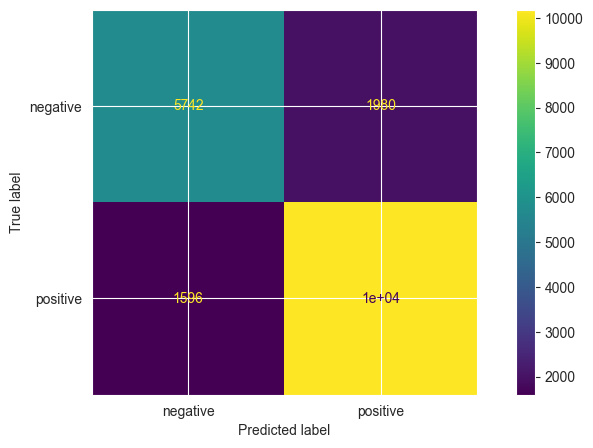

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10, 5))
pred = lrModel.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)

## Naive Bayes

Let's apply the pre-implemented Naive Bayes classifier from $\textit{sklearn}$.

In [ ]:
from sklearn.naive_bayes import MultinomialNB

nvModel = MultinomialNB()
nvModel.fit(X_train, y_train)

In [ ]:
print("Length of the model classes: ", len(nvModel.classes_))
print("Type of the model classes  : ", nvModel.classes_)
print("Model accuracy             : ", nvModel.score(X_test, y_test))

Length of the model classes:  2
Type of the model classes  :  ['negative' 'positive']
Model accuracy             :  0.8024919243193355


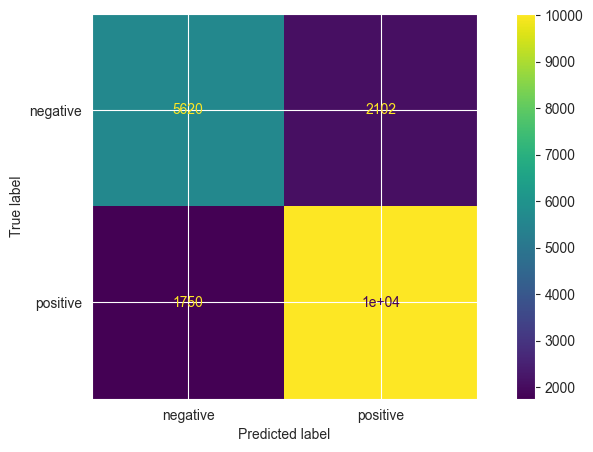

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
pred = nvModel.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)

## K-Nearest Neighbors

Let's apply the pre-implemented KNN classifier from $\textit{sklearn}$, with the number of neighbors that goes from 1 to 8.

In [ ]:
k_range = range(1, 8) # range(1, 8)
scores = {}
scores_list = []

In [ ]:
for k in tqdm(k_range):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    scores_list.append(neigh.score(X_test, y_test))

100%|██████████| 7/7 [02:21<00:00, 20.24s/it]


Text(0, 0.5, 'Testing Accuracy')

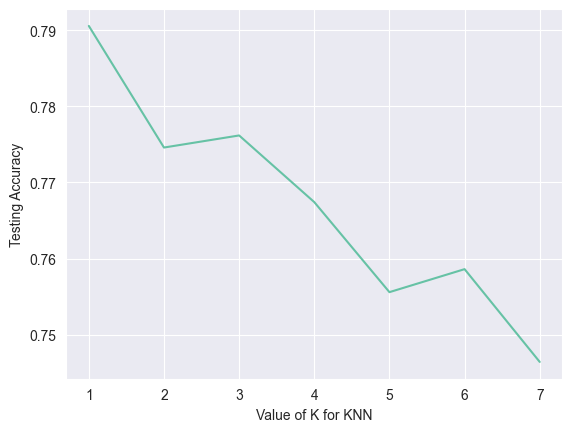

In [ ]:
%matplotlib inline

plt.plot(k_range, scores_list)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

As we can see from the plot, we get the best accuracy for K=1 or K=3.

<hr>

# Our own Model and Train, with Softmax Classifier

In the cell below are the functions we implemented for the Softmax classifier.We've used the library sparse.csr_matrix since our matrix comes from cv.fit_transform, this function return a matrix full of 0s since each sentence contains few words compared to their total. Thanks to sparse.crs_matrix library we reduced the time calculation.

In [ ]:
def softmax(theta, X):
    # Compute the associated probability for each sample and each class.

    logits_exp = np.exp(sparse.csr_matrix.dot(X,theta))
    softmax = logits_exp / np.sum(logits_exp, axis=1, keepdims=True) 
    
    return softmax


def CELoss(theta, X, y_onehot):
    # Compute softmax regression model and Cross Entropy loss.
   
    my_multiplication = y_onehot * np.log(softmax(theta, X)) 
    loss = - np.sum(my_multiplication, axis=1, keepdims = True) 
    
    return sparse.csr_matrix.mean(loss)


def CELoss_jacobian(theta, X, y_onehot):
    # Function to compute gradient of the cross entropy loss with respect the parameters.
    
    jacobian = - sparse.csr_matrix.dot(X.T, y_onehot - softmax(theta,X))/len(y_onehot)
    
    return jacobian

The main function of the classifier.

In [ ]:
def fit_softmax_classifier(X_train, y_onehot_train, alpha, n_iter):
    
    log_l_history=[]

    W=np.random.normal(0, 1, (X_train.shape[1], y_onehot_train.shape[1]))
    theta0=W
    
    for i in tqdm(range(n_iter)):
        log_l_history.append(CELoss(W, X_train, y_onehot_train))
        W = W - alpha*CELoss_jacobian(W, X_train, y_onehot_train)
        
    theta_final=W

    return theta0, theta_final, log_l_history

Convert labels to numbers.

In [ ]:
def convert_text(x):
    if x == "anger":
        return 0
    elif x == "fear":
        return 1
    elif x == "joy":
        return 2
    elif x == "love":
        return 3
    elif x == "sadness":
        return 4
    elif x == "surprise":
        return 5

new_y_train = y_train.apply(lambda x: convert_text(x))

In [ ]:
def convert_text(x):
    if x == "positive":
        return 1
    elif x == "negative":
        return 0

new_y_train = y_train.apply(lambda x: convert_text(x))

And define the OneHot matrix that contains the true labels.

The result is going to be in form of lists, for each element we have a list of all zeros except for the index of the true label.

In [ ]:
def class2OneHot(vec):
    out_sparse = sparse.csr_matrix((np.ones(vec.shape[0]), (vec, np.array(range(vec.shape[0])))))
    out_onehot = np.array(out_sparse.todense()).T
    return out_onehot

y_onehot = class2OneHot(new_y_train)

Let's train the classifier!

In [ ]:
theta0, theta_final, log_l_history = fit_softmax_classifier(X_train, y_onehot, alpha=5, n_iter=10000)

100%|██████████| 10000/10000 [02:22<00:00, 70.20it/s]


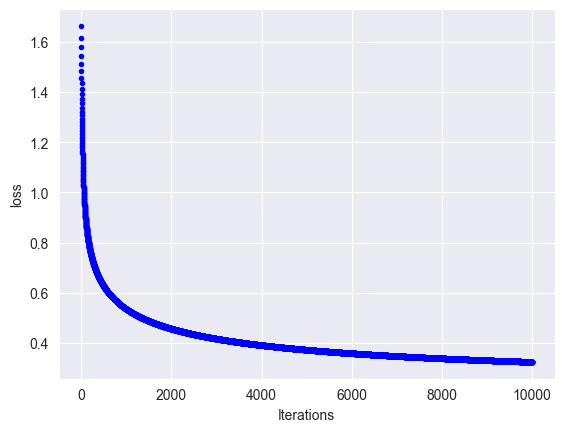

In [ ]:
fig,ax = plt.subplots(num=2)

ax.set_ylabel('loss')
ax.set_xlabel('Iterations')
_=ax.plot(range(len(log_l_history)), log_l_history,'b.')

In [ ]:
loss = CELoss(theta_final, X_train, y_onehot)
loss

0.32386120567611476

In [ ]:
def compute_accuracy(theta, X, y):

    accuracy = np.mean(np.argmax(softmax(theta, X), axis = 1) == y)

    return accuracy

In [ ]:
new_y_test = y_test.apply(lambda x: convert_text(x))

In [ ]:
compute_accuracy(theta_final, X_train, np.array(new_y_train))

0.8661966414562235

([<matplotlib.axis.YTick at 0x23abdad3820>,
 [Text(0, 0, 'negative'), Text(0, 1, 'positive')])

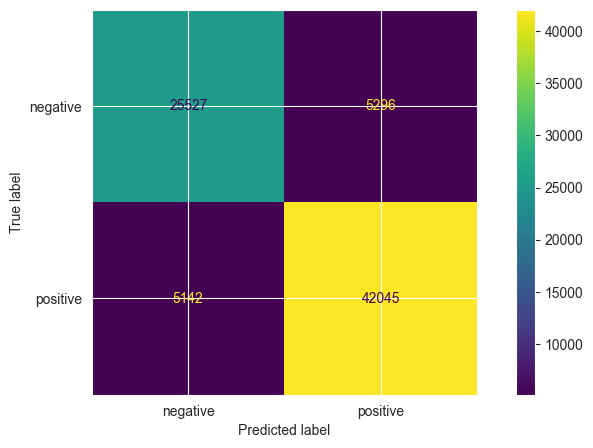

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
pred = np.argmax(softmax(theta_final, X_train), axis = 1)
ConfusionMatrixDisplay.from_predictions(np.array(new_y_train), pred, ax=ax)
plt.xticks([0, 1], ['negative', 'positive'])
plt.yticks([0, 1], ['negative', 'positive'])

In [ ]:
compute_accuracy(theta_final, X_test, np.array(new_y_test))

0.8048505358150028

([<matplotlib.axis.YTick at 0x23abda38820>,
 [Text(0, 0, 'negative'), Text(0, 1, 'positive')])

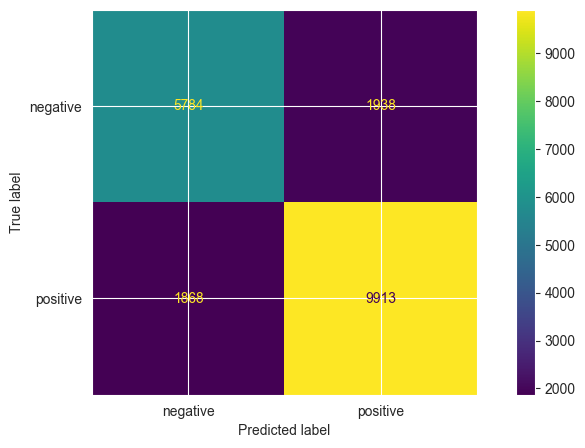

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
pred = np.argmax(softmax(theta_final, X_test), axis = 1)
ConfusionMatrixDisplay.from_predictions(np.array(new_y_test), pred, ax=ax)
plt.xticks([0, 1], ['negative', 'positive'])
plt.yticks([0, 1], ['negative', 'positive'])

This function takes in input two arguments: theta and X_train. Returns a list of the indices of the maximum element in each row of the softmax calculation.

In [ ]:
def get_argmax_output(theta, X_train):
    argmax_output = [np.argmax(output) for output in softmax(theta,X_train)]
    return argmax_output

The main informations for our analysis

In [ ]:
from sklearn import metrics
print(metrics.classification_report(np.array(new_y_test), get_argmax_output(theta_final, X_test)))

              precision    recall  f1-score   support

           0       0.76      0.75      0.75      7722
           1       0.84      0.84      0.84     11781

    accuracy                           0.80     19503
   macro avg       0.80      0.80      0.80     19503
weighted avg       0.80      0.80      0.80     19503



Precision = it is the proportion of true positive predictions made by the model out of all positive predictions made by the model, more discursively, is a measure of the accuracy of the positive predictions made by a machine learning model

Recall = it is a measure of the model's ability to correctly identify all positive cases in the test dataset, or better, a proportion of true positive predictions made by the model out of all actual positive cases in the test dataset.

So based on the above definition the model appears to perform well on this test dataset since we see good precision and recall for both classes and since they are balanced even f1 has good value.




